### LLM Answers and Hallucinations Visualization

### Experiment Overview

This notebook presents an analysis using the [Natural Questions Dataset](https://www.kaggle.com/datasets/frankossai/natural-questions-dataset) as a basis for exploring the clustering and positioning of various answer types generated by LLMs. Specifically, we apply UMAP with random seeds for dimensionality reduction and examine Euclidean distances between centroids to assess the relative positioning and separability of different response types.

The following datasets, derived from the Natural Questions dataset, will be used:

1. **NQ-true-answers_llama3.1.csv**: Contains true answers directly from the Natural Questions dataset.
2. **NQ-llm-correct_answers_llama3.1.csv**: Contains answers generated by the LLaMA 3.1 model, which match the true answers.
3. **NQ-llm-factual_inaccuracy_llama3.1.csv**: Contains answers generated by the LLaMA 3.1 model that include hallucinations or factual inaccuracies.

For each experiment, we:
- **Apply UMAP with a different random seed**: This introduces variability in the 2D projections, helping identify stable patterns and variations across runs.
- **Measure Euclidean Distance between Centroids**: Calculate the Euclidean distance between the centroids of each answer type (true answers, correct LLM answers, and hallucinations) to assess their relative separability.

Through this analysis, we aim to better understand the distribution of true answers, correct LLM responses, and hallucinated responses in embedding space.


#### Workflow
- Data Preprocessing: Clean and prepare datasets for embedding.

- Embedding with LLMs: Generate embeddings for each entry in the datasets using a large language model.

- Dimensionality Reduction with UMAP: Reduce embeddings to 2D to enable visual analysis.

- Visualization: Plot the 2D embeddings for each group, using different colors to distinguish true answers, LLM answers, and hallucinations.

- Centroid Analysis: Calculate centroids for each group and measure the distances between them to assess the relative positioning of each response type.

In [6]:
import logging
import pandas as pd 
from src.services.embedding_visualizer_service import EmbeddingVisualizer

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


BASIC_EXPERIMENT_ROWS = 50
MID_EXPERIMENT_ROWS = 200
ADVANCED_EXPERIMENT_ROWS = 500

def read_and_combine_df(rows):
    # Read LLM responses datasets 
    true_expected_answers = pd.read_csv('./data/llm_responses/NQ-true_expected_long_answers_llama3.1.csv', nrows=rows)    
    correct_answers = pd.read_csv('./data/llm_responses/NQ-llm-correct_answers_llama3.1.csv', nrows=rows)    
    fabrications = pd.read_csv('./data/llm_responses/NQ-llm-fabrication_llama3.1.csv', nrows=rows)    

    #for i in range(500):        
    #    print(len(str(correct_answers['llama3.1'][i]).split()))
    
    # Find common uids across all DataFrames
    common_uids = set(true_expected_answers['uid']).intersection(true_expected_answers['uid']).intersection(true_expected_answers['uid'])    
    # Filter each DataFrame to retain only rows with common uids
    true_expected_answers = true_expected_answers[true_expected_answers['uid'].isin(common_uids)]
    correct_answers = correct_answers[correct_answers['uid'].isin(common_uids)]
    fabrications = fabrications[fabrications['uid'].isin(common_uids)]

    # Rename columns and concatenate datasets, keeping only the required columns
    df_combined = pd.concat([
        true_expected_answers.rename(columns={'true_expected_long_answers_embedding_llama3.1': 'NQ TRUE expected answers'})[['NQ TRUE expected answers']],
        correct_answers.rename(columns={'embedding_llama3.1': 'correct_answers_llama3.1'})[['correct_answers_llama3.1']],
        fabrications.rename(columns={'embedding_llama3.1': 'hallucinations_fabrication_llama3.1'})[['hallucinations_fabrication_llama3.1']]
    ], axis=1)

    logging.info(f"Data loaded with shape {df_combined.shape}")
    return df_combined

def init_embedding_visualizer_preprocess_embeddings(df_combined) -> EmbeddingVisualizer:
    vis = EmbeddingVisualizer(df=df_combined)
    vis.convert_columns_to_float_arrays()
    vis.process_embeddings_padding()
    return vis

##### Experiment with BASIC_EXPERIMENT_ROWS entities for the each group

2024-11-06 20:39:33,502 - INFO - Data loaded with shape (50, 3)
2024-11-06 20:39:34,930 - INFO - Max length across specified columns: 4096
2024-11-06 20:39:34,931 - INFO - ['NQ TRUE expected answers', 'correct_answers_llama3.1', 'hallucinations_fabrication_llama3.1']
2024-11-06 20:39:34,931 - INFO - Padding applied. Reduced embeddings shape: (50, 3)


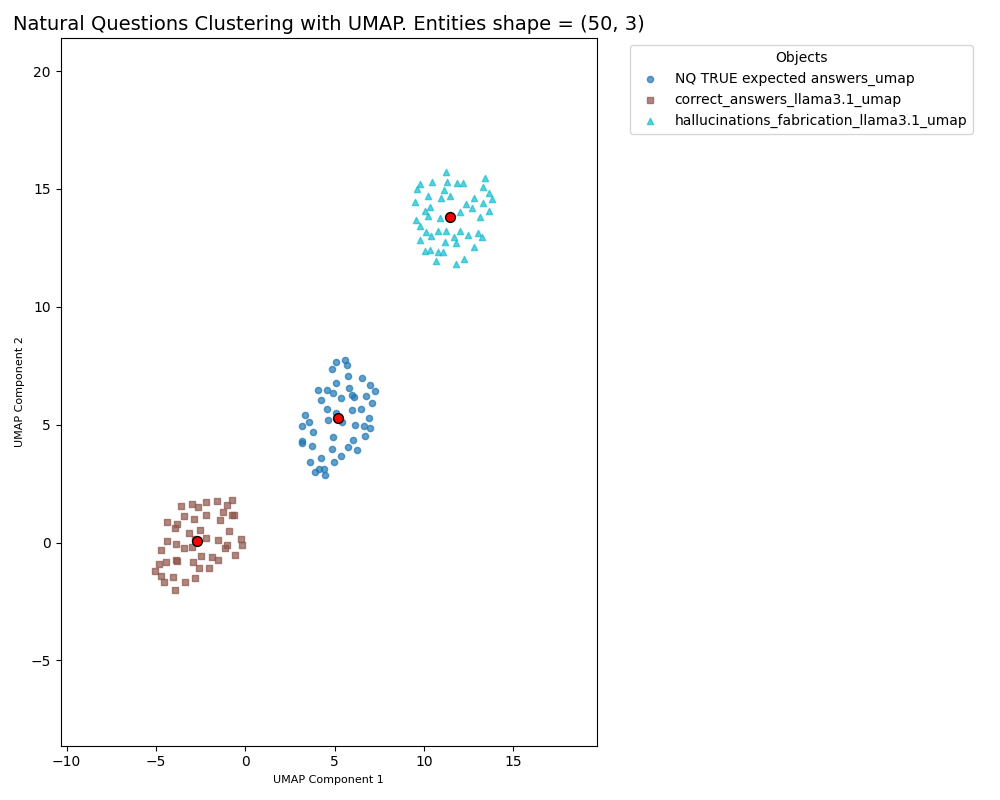

In [7]:
from PIL import Image
from src.services.similarity_service import find_centroids
from IPython.display import display, Image as IPImage

df_combined = read_and_combine_df(rows=BASIC_EXPERIMENT_ROWS)
vis = init_embedding_visualizer_preprocess_embeddings(df_combined)
df_umap = vis.apply_umap(n_components=2, rand_state=42)
centroids_df = find_centroids(df_umap)
img_buff = vis.plot_umap_2d(df=df_umap, 
                 centroids=centroids_df, 
                 title=f"Natural Questions Clustering with UMAP. Entities shape = {df_combined.shape}")
display(Image.open(img_buff))

#### Generate Images with Different Random Seed

Generate multiple visualizations by applying different random seeds. This allows exploration of varied clustering and layout patterns within the 2D embeddings, helping to identify stable patterns and potential variations across different runs.

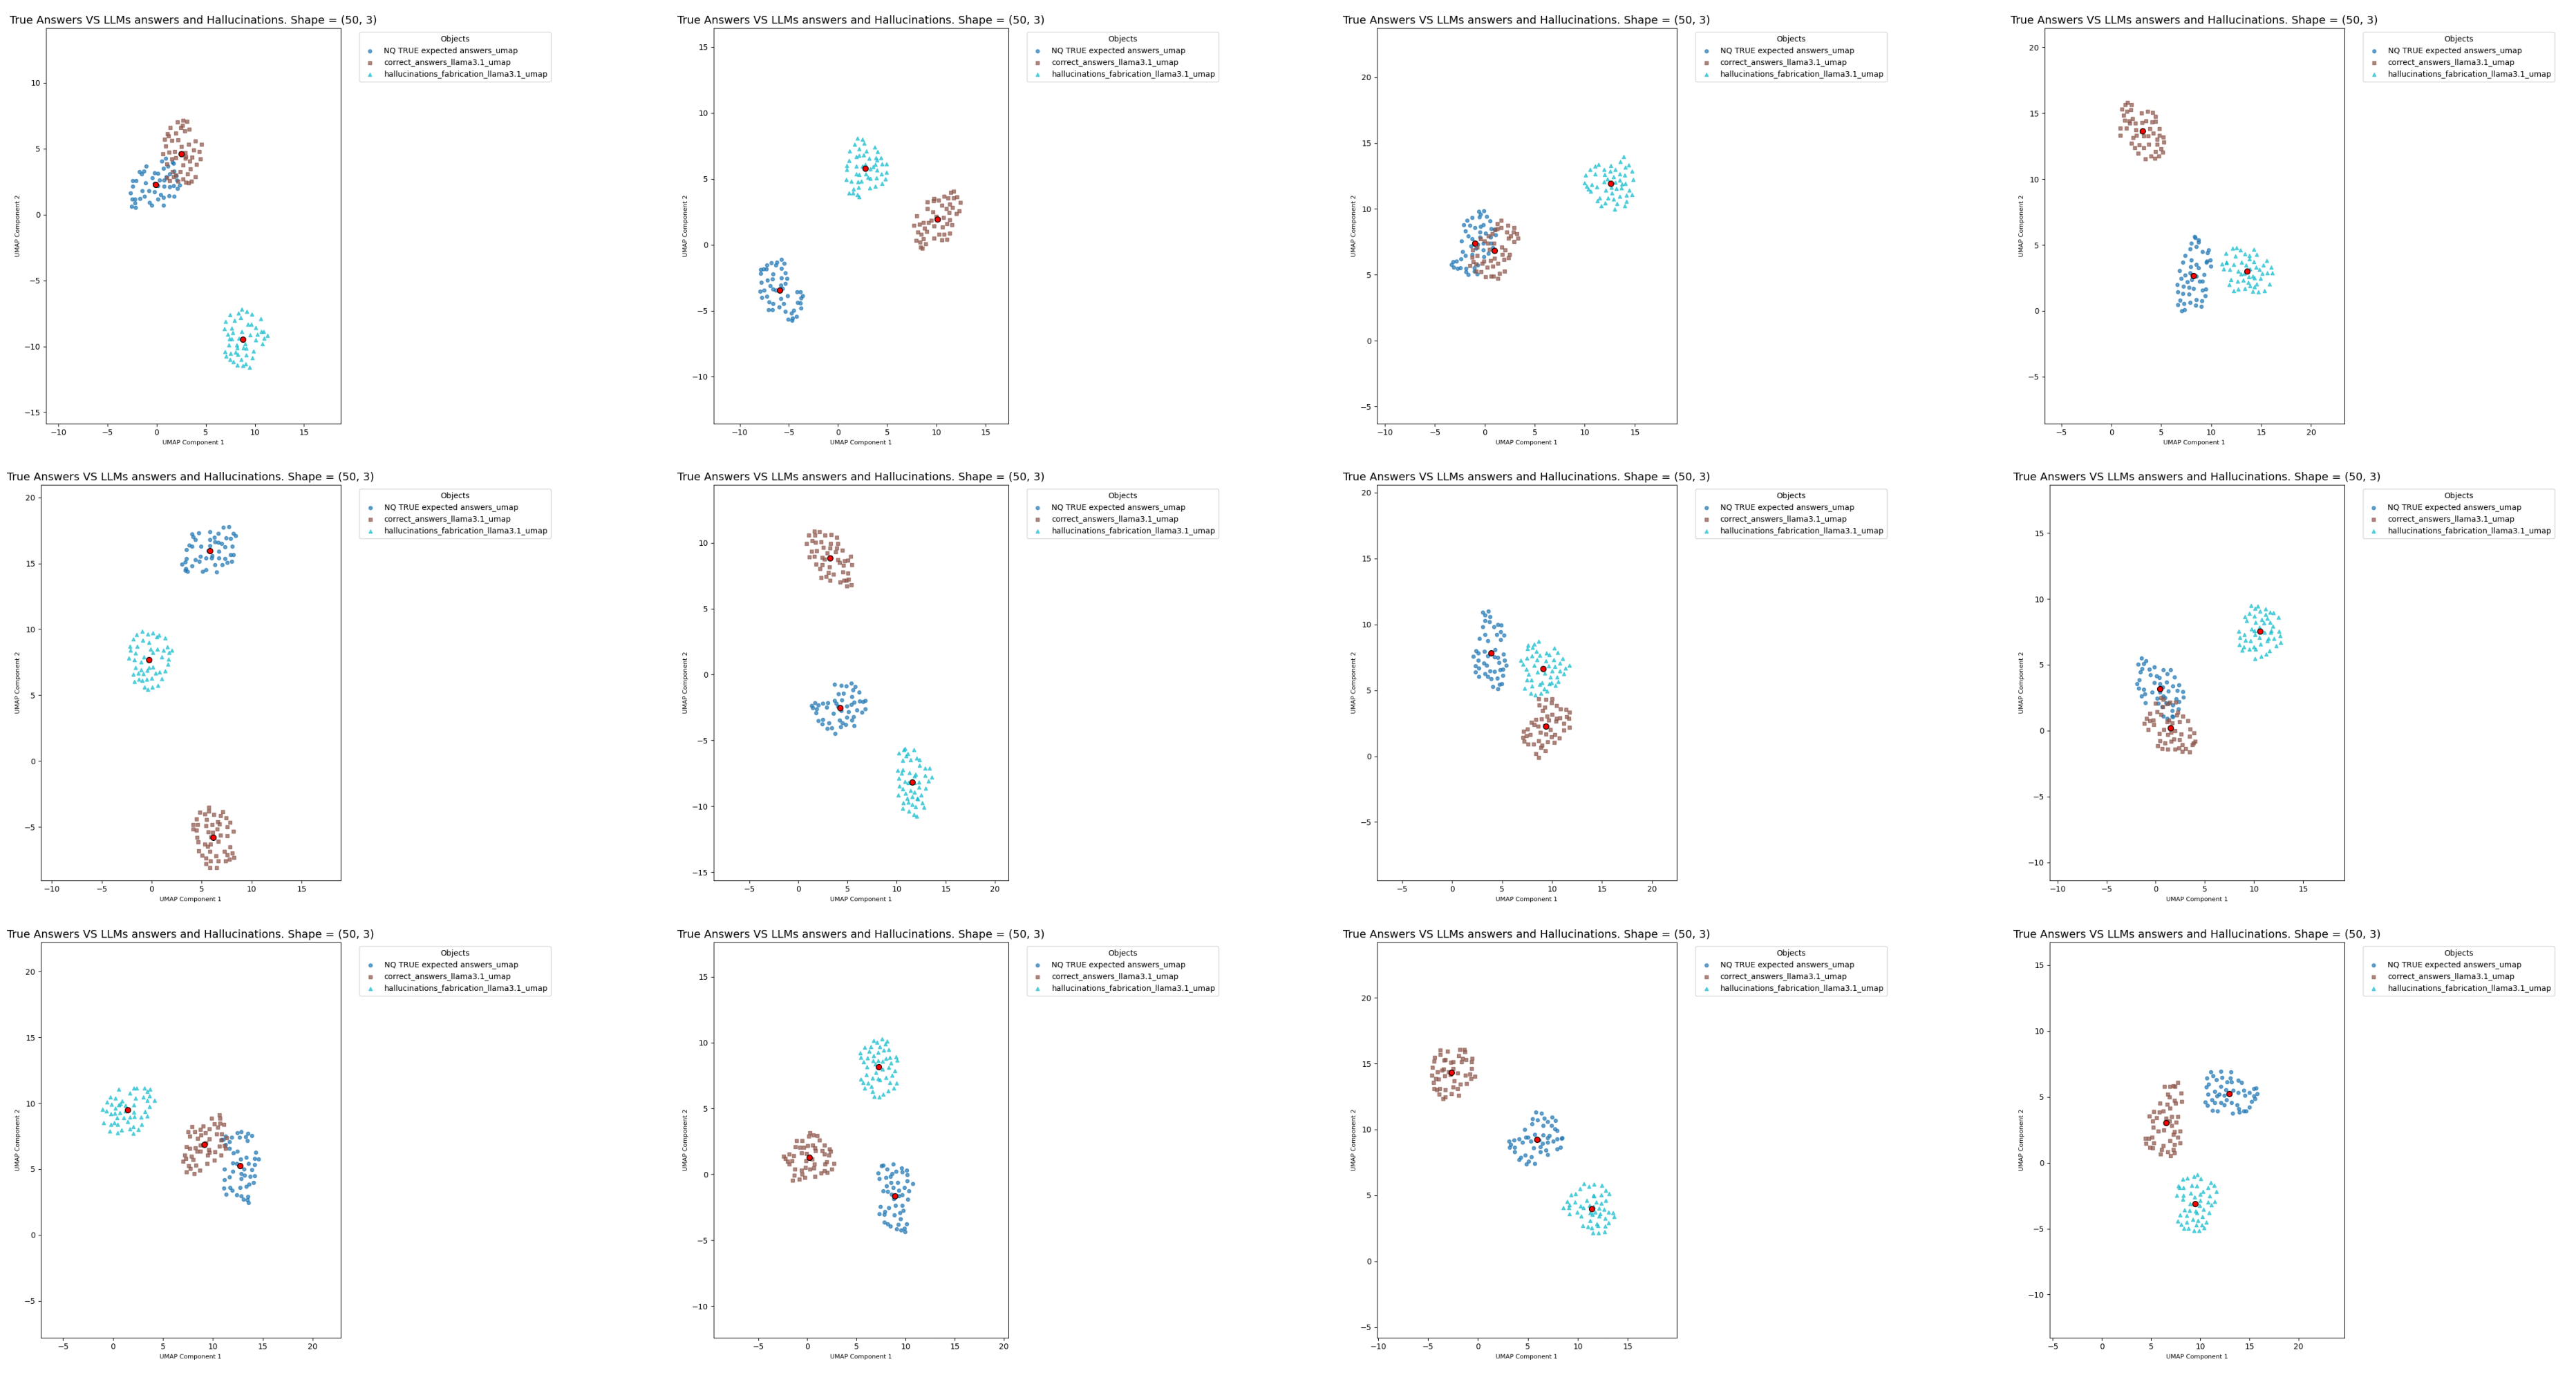

In [8]:
from src.services.similarity_service import find_centroids

imgs = []
df_umap = vis.apply_umap(n_components=2, rand_state=42)
centroids_df = pd.DataFrame(columns=df_umap.columns)
for i in range(12):    
    df_umap = vis.apply_umap(n_components=2, rand_state=i)
    centroids_df = find_centroids(df_umap)
    img_buff = vis.plot_umap_2d(df=df_umap, 
                 centroids=centroids_df, 
                 title=f"True Answers VS LLMs answers and Hallucinations. Shape = {df_umap.shape}")
    imgs.append(img_buff)

vis.plot_list_images_as_matrix(lines=3, columns=4, imgs=imgs)

#### Calculate Distance Between Centroids with Random Seed

Calculate the Euclidean distance between centroids of each class (true answers, LLM answers, and hallucinations) using different random seeds. This provides insight into the relative positioning and separability of these groups across multiple runs.

In [9]:
import numpy as np
from src.services.similarity_service import centroids_df_to_dict, euclidean_distance_dots, find_centroids
import random


def mesure_similarity(experiment = 2, print_data = 1, shape = ''):
    logging.info(f"Data shape for similarity measurement = {shape}")        
    euclidean_distances = {}
    for i in range(experiment+1):
        df_umap = vis.apply_umap(n_components=2, rand_state=random.randint(0, 10**9))
        centroids_df = find_centroids(df_umap)
        centroids_dict = centroids_df_to_dict(centroids_df)
        distance = euclidean_distance_dots(centroids_dict)

        for k, v in distance.items(): 
            tmp = euclidean_distances.get(k, [])
            tmp.append(v)
            euclidean_distances[k] = tmp
        if i != 0 and i % print_data == 0:
            #print results 
            average_distances = {k: sum(v) / len(v) for k, v in euclidean_distances.items()}                                      
            vis.plot_average_similarities_result(f'Data shape = {shape}, Random SEED generated {i} times. Mean calculation results:', average_distances)


2024-11-06 20:40:13,431 - INFO - Data shape for similarity measurement = (50, 3)


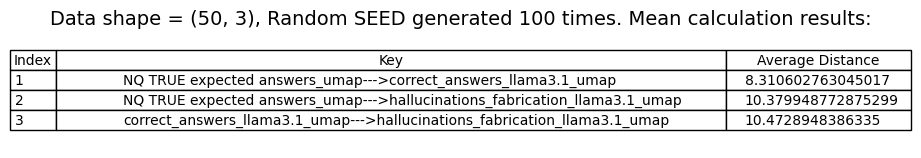

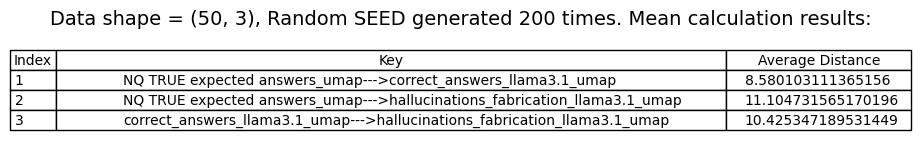

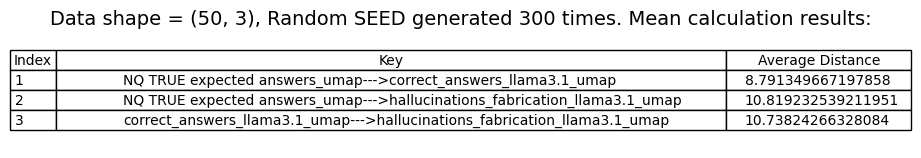

In [10]:
mesure_similarity(experiment=300, print_data=100 , shape=df_combined.shape) 

#### Experiment with MID_EXPERIMENT_ROWS entities for the each group

2024-11-06 21:05:50,101 - INFO - Data loaded with shape (200, 3)
2024-11-06 21:05:56,209 - INFO - Max length across specified columns: 4096
2024-11-06 21:05:56,210 - INFO - ['NQ TRUE expected answers', 'correct_answers_llama3.1', 'hallucinations_fabrication_llama3.1']
2024-11-06 21:05:56,210 - INFO - Padding applied. Reduced embeddings shape: (200, 3)


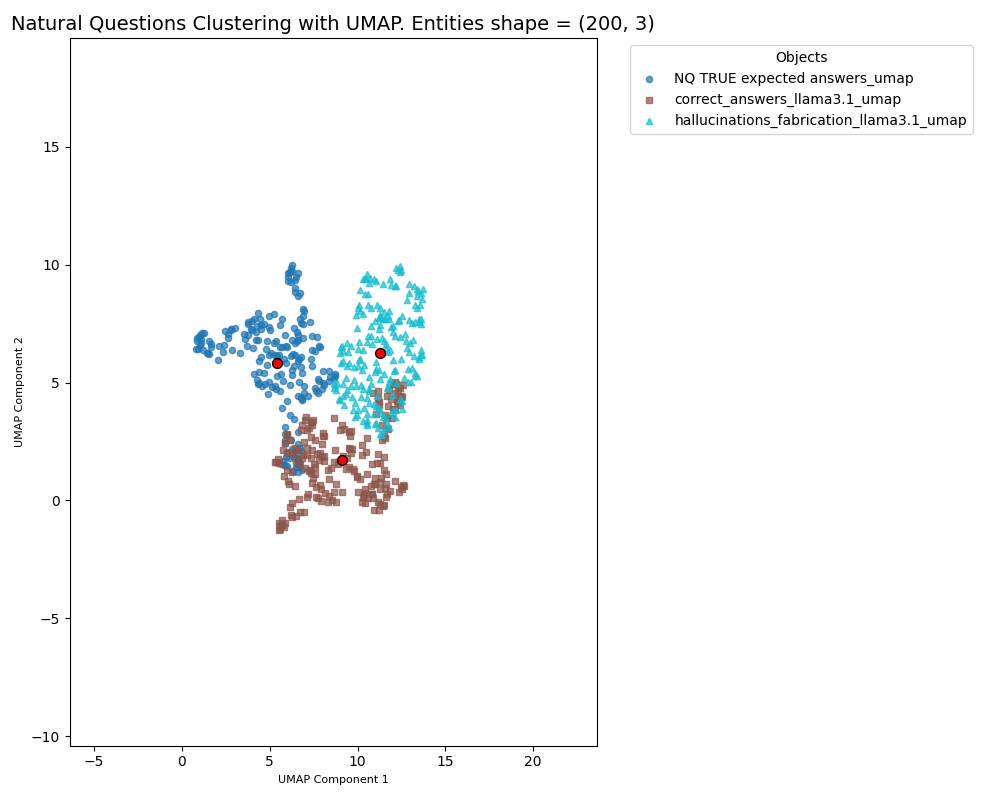

In [11]:
from PIL import Image
from src.services.similarity_service import find_centroids
from IPython.display import display, Image as IPImage

df_combined = read_and_combine_df(rows=MID_EXPERIMENT_ROWS)
vis = init_embedding_visualizer_preprocess_embeddings(df_combined)
df_umap = vis.apply_umap(n_components=2, rand_state=16)
centroids_df = find_centroids(df_umap)
img_buff = vis.plot_umap_2d(df=df_umap,                             
                 centroids=centroids_df, 
                 title=f"Natural Questions Clustering with UMAP. Entities shape = {df_combined.shape}")
display(Image.open(img_buff))

2024-11-06 21:06:08,499 - INFO - Data shape for similarity measurement = (200, 3)


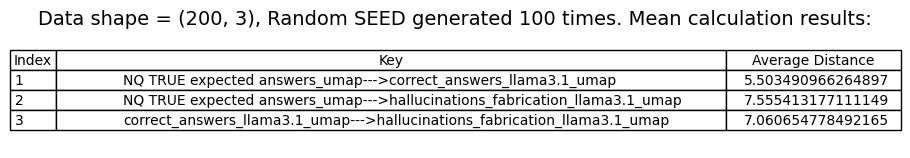

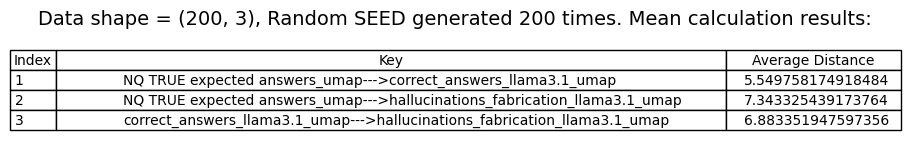

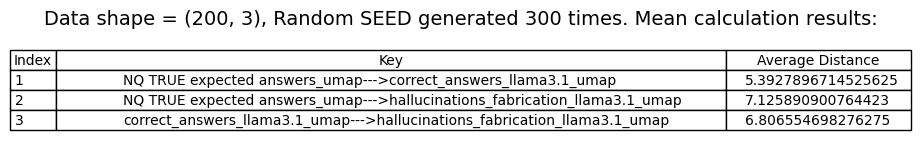

In [12]:
mesure_similarity(experiment=300, print_data=100 , shape=df_combined.shape)

#### Experiment with ADVANCED_EXPERIMENT_ROWS entities for the each group

2024-11-06 21:23:16,643 - INFO - Data loaded with shape (500, 3)
2024-11-06 21:23:31,812 - INFO - Max length across specified columns: 4096
2024-11-06 21:23:31,812 - INFO - ['NQ TRUE expected answers', 'correct_answers_llama3.1', 'hallucinations_fabrication_llama3.1']
2024-11-06 21:23:31,813 - INFO - Padding applied. Reduced embeddings shape: (500, 3)


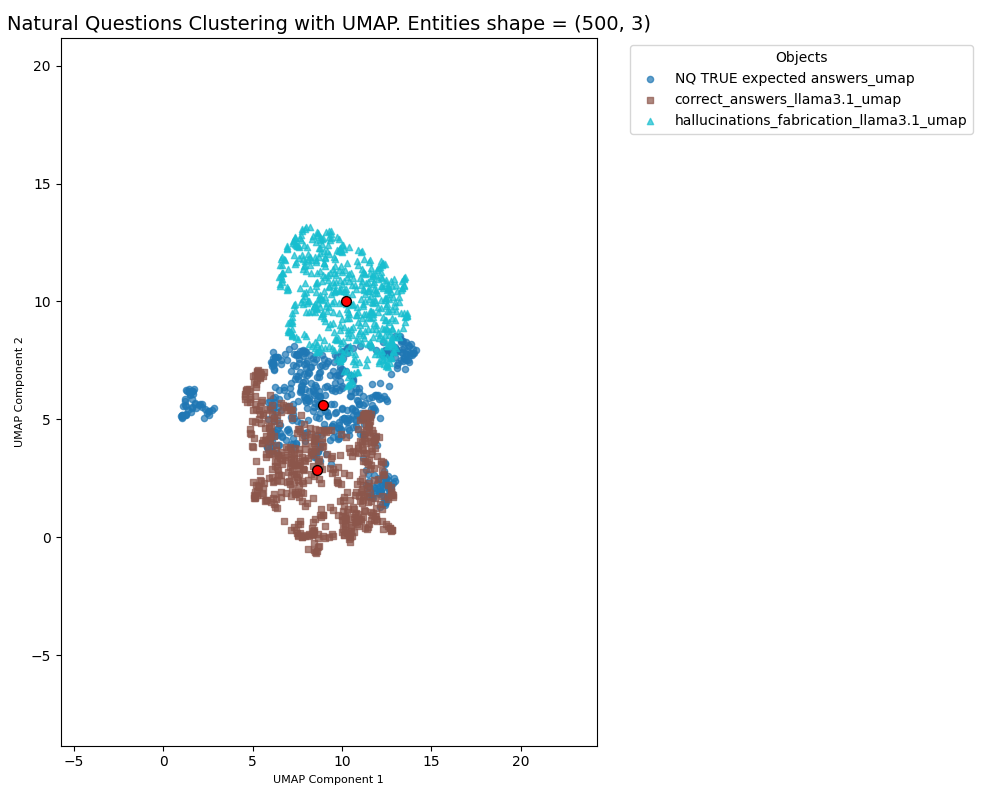

In [13]:
df_combined = read_and_combine_df(rows=ADVANCED_EXPERIMENT_ROWS)
vis = init_embedding_visualizer_preprocess_embeddings(df_combined)
df_umap = vis.apply_umap(n_components=2, rand_state=32)
centroids_df = find_centroids(df_umap)
img_buff = vis.plot_umap_2d(df=df_umap,                             
                 centroids=centroids_df, 
                 title=f"Natural Questions Clustering with UMAP. Entities shape = {df_combined.shape}")
display(Image.open(img_buff))

2024-11-06 21:23:40,617 - INFO - Data shape for similarity measurement = (500, 3)


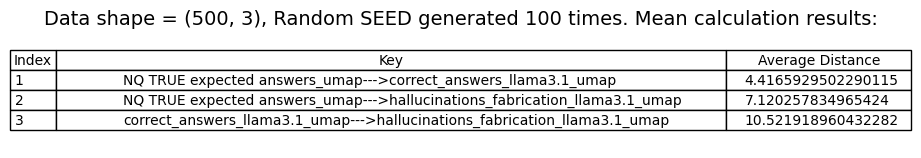

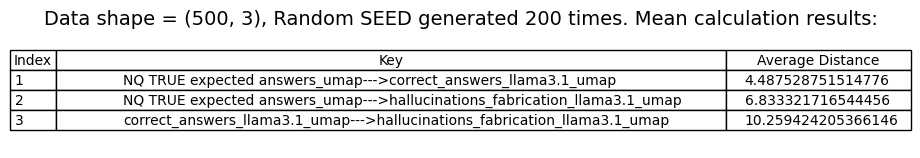

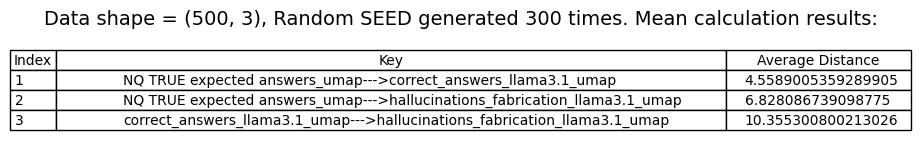

In [14]:
mesure_similarity(experiment=300, print_data=100 , shape=df_combined.shape)